# Data Science Challenge
-----------------------

## 1. Data pre-Processing

## 2. Feature engineering 

## 3. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt

from source.utils import haversine_distance 

%matplotlib inline

In [3]:
df_event = pd.read_csv('./data/events.csv')
df_iata = pd.read_csv('./data/iata.csv')

In [4]:
df_event.shape, df_iata.shape

((47007, 9), (500, 3))

## 1. Data pre-Processing

#### A. Check the NaN in the events data

In [5]:
df_event.isna().sum()

ts               0
event_type       0
user_id          0
date_from       22
date_to          3
origin           0
destination      0
num_adults       0
num_children     0
dtype: int64

##### [ Comments ] 
There is 2 columns with NaN. <br>
It seems like NaN data is relatively small compared to the size of the entire data. <br>
22 / 47007 , 3 / 47007 

#### B. Check the effectivness of this NaN data for task


In [6]:
df_event[df_event['date_to'].isna()]['event_type'].value_counts()

search    3
Name: event_type, dtype: int64

In [7]:
df_event[df_event['date_from'].isna()]['event_type'].value_counts()/len(df_event[df_event['date_from'].isna()]['event_type'])

search    0.954545
book      0.045455
Name: event_type, dtype: float64

##### [ Comments ]
NaN data contains Only 1 'book' event_type. <br>
From my understanding, 'book' event won't work without a 'date_from' and 'date_to'.<br>
So, this data is wrong some way.

#### When I drop NaN data, I want to make sure the same user is in the remaining data.

In [8]:
user_id_toNaN = df_event[df_event['date_to'].isna()]['user_id'].unique().tolist()

In [9]:
user_id_fromNaN = df_event[df_event['date_from'].isna()]['user_id'].unique().tolist()

In [10]:
drop_index = df_event[(df_event['date_to'].isna())|(df_event['date_from'].isna())].index

In [11]:
set(df_event.drop(drop_index, axis=0)['user_id'].unique()).intersection(user_id_toNaN)

set()

In [12]:
set(df_event.drop(drop_index, axis=0)['user_id'].unique()).intersection(user_id_fromNaN)

{'786588'}

In [13]:
df_event[df_event['user_id'] == '786588']

,ts,event_type,user_id,date_from,date_to,origin,destination,num_adults,num_children
41754,2017-04-27 13:20:22,search,786588,NaN,2017-06-28,AMS,MSP,0,0
45467,2017-04-27 13:07:25,search,786588,2017-06-14,2017-06-29,AMS,DTT,2,2


##### [ Comments ]
Only one user_id coexists with NaN data and dropped NaN data.<br>
Drop all NaN data <br>


In [14]:
df_event = df_event.drop(drop_index, axis=0)
df_event.shape

(46985, 9)

#### C. Check the uniquness of iata_code

In [15]:
df_iata.head(2)

,iata_code,lat,lon
0,LON,51.50,-0.17
1,MOW,55.75,37.70


In [16]:
len(set(df_event['origin'].unique())-set(df_iata['iata_code'].unique()))

0

In [17]:
len(set(df_event['destination'].unique())-set(df_iata['iata_code'].unique()))

0

In [18]:
df_iata['iata_code'].value_counts()[:5]

RDU    3
CKG    3
URC    3
KWI    2
PIT    2
Name: iata_code, dtype: int64

In [19]:
len(df_iata['iata_code'].unique())

298

##### [ Comments ]
There are some non-unique codes in iata data. So take only the first value.

In [20]:
df_iata = df_iata.drop_duplicates(['iata_code'])
df_iata.shape

(298, 3)

#### D. Change the datetime data type

In [22]:
df_event['ts'] = df_event['ts'].astype('datetime64')
df_event['date_from'] = df_event['date_from'].astype('datetime64')
df_event['date_to'] = df_event['date_to'].astype('datetime64')

## 2. Feature Engineering

#### A. Add number of activities of uninque user

In [24]:
df_event = df_event.sort_values(by = ['user_id', 'ts'], ascending=True)

In [25]:
df_event['act_count'] = df_event.groupby('user_id').cumcount()+1

In [26]:
df_event.head(10)

,ts,event_type,user_id,date_from,date_to,origin,destination,num_adults,num_children,act_count
10873,2017-04-29 17:59:51,search,000069,2017-05-10,2017-05-26,FRA,ALG,2,3,1
12331,2017-04-28 19:14:23,search,00019d,2017-09-15,2017-10-13,PAR,SSA,4,0,1
26506,2017-04-24 21:25:10,search,0002e3,2017-05-01,2017-05-01,PAR,ATH,1,0,1
31638,2017-04-27 16:34:02,search,000332,2017-06-08,2017-07-07,NCE,TLV,1,0,1
20112,2017-04-27 16:35:35,search,000332,2017-06-08,2017-07-07,NCE,TLV,1,0,2
37051,2017-04-27 16:39:10,search,000332,2017-06-08,2017-07-07,NCE,TLV,2,0,3
24297,2017-04-27 21:24:01,search,000332,2017-06-08,2017-07-07,TLV,NCE,2,0,4
25896,2017-04-29 01:06:18,search,0004e1,2017-07-19,2017-07-25,MUC,ROM,1,0,1
21959,2017-04-29 01:06:41,search,0004e1,2017-07-19,2017-07-25,MUC,ROM,1,0,2
16864,2017-04-29 23:42:19,search,0004f1,2017-09-15,2017-10-05,LYS,YUL,2,0,1


In [29]:
df_event[df_event['event_type']=='book']['user_id'].value_counts()[:5]

690a8c    3
08e914    2
57da52    2
1e636b    1
478293    1
Name: user_id, dtype: int64

In [311]:
haversine_distance(df_iata.iloc[0,1:].tolist(), df_iata.iloc[1,1:].tolist())

2508.7359723119966

In [316]:
df_iata[df_iata['iata_code']=='URC'].drop_duplicates(['iata_code'])

,iata_code,lat,lon
251,URC,43.8,87.6


In [317]:
df_iata.drop_duplicates(['iata_code']).shape

(298, 3)

In [313]:
df_event[df_event['destination']=='URC']

,ts,event_type,user_id,date_from,date_to,origin,destination,num_adults,num_children
32676,2017-04-23 22:36:41,search,cfafc1,2017-11-21,2017-12-13,MUC,URC,1,0
36291,2017-04-29 01:54:32,search,94de3c,2017-06-19,2017-07-02,FRA,URC,3,0


In [314]:
pd.merge(df_event[df_event['destination']=='URC'], df_iata[df_iata['iata_code']=='URC'], how='inner', left_on='destination', right_on='iata_code')

,ts,event_type,user_id,date_from,date_to,origin,destination,num_adults,num_children,iata_code,lat,lon
0,2017-04-23 22:36:41,search,cfafc1,2017-11-21,2017-12-13,MUC,URC,1,0,URC,43.80,87.60
1,2017-04-23 22:36:41,search,cfafc1,2017-11-21,2017-12-13,MUC,URC,1,0,URC,43.91,87.47
2,2017-04-23 22:36:41,search,cfafc1,2017-11-21,2017-12-13,MUC,URC,1,0,URC,43.88,87.48
3,2017-04-29 01:54:32,search,94de3c,2017-06-19,2017-07-02,FRA,URC,3,0,URC,43.80,87.60
4,2017-04-29 01:54:32,search,94de3c,2017-06-19,2017-07-02,FRA,URC,3,0,URC,43.91,87.47
5,2017-04-29 01:54:32,search,94de3c,2017-06-19,2017-07-02,FRA,URC,3,0,URC,43.88,87.48


In [298]:
df_iata['iata_code'].value_counts()

RDU    3
URC    3
CKG    3
AYT    2
CCS    2
      ..
NYC    1
CGK    1
SAO    1
DCA    1
OTP    1
Name: iata_code, Length: 298, dtype: int64

In [296]:
len(set(df_event['destination'].unique())-set(df_iata['iata_code'].unique()))

0

In [297]:
len(set(df_event['origin'].unique())-set(df_iata['iata_code'].unique()))

0

In [294]:
df_event[df_event['destination']=='RDU']

,ts,event_type,user_id,date_from,date_to,origin,destination,num_adults,num_children
10968,2017-04-29 20:47:24,search,da0445,2017-04-30,2017-05-11,BER,RDU,1,0
13706,2017-04-23 13:17:27,search,3315e6,2017-05-14,2017-06-25,MUC,RDU,1,0
13776,2017-04-23 12:50:09,search,a74d74,2017-06-05,2017-06-05,SFO,RDU,1,0
24294,2017-04-27 17:23:47,search,15a1f9,2017-12-12,2017-12-19,TLS,RDU,2,2
25267,2017-04-23 15:11:08,search,936306,2017-08-26,2017-09-13,FRA,RDU,1,0
32693,2017-04-23 14:59:24,search,936306,2017-08-26,2017-09-13,FRA,RDU,1,0
37102,2017-04-23 18:40:08,search,3d9940,2017-07-27,2017-08-03,FRA,RDU,2,0
37533,2017-04-23 18:55:41,search,3d9940,2017-07-28,2017-08-04,PRG,RDU,2,0
38596,2017-05-01 14:27:29,search,fb004a,2017-06-04,2017-06-07,MUC,RDU,1,0


In [4]:
df_event.head(4)

,ts,event_type,user_id,date_from,date_to,origin,destination,num_adults,num_children
0,2017-04-27 11:06:51,search,60225f,2017-06-01,2017-06-07,PAR,NYC,6,1
1,2017-04-27 20:15:27,book,e5d69e,2017-08-12,2017-09-02,FRA,WAS,3,1
2,2017-04-27 23:03:43,book,f953f0,2017-10-08,2017-10-11,BER,CGN,2,0
3,2017-04-27 15:17:50,book,794d35,2017-04-28,2017-05-01,BER,BCN,1,0


In [37]:
# Dealing with NaN in tricky 
df_event.isna().sum()

ts               0
event_type       0
user_id          0
date_from       22
date_to          3
origin           0
destination      0
num_adults       0
num_children     0
dtype: int64

In [39]:
df_event[df_event['date_from'].isna()]

,ts,event_type,user_id,date_from,date_to,origin,destination,num_adults,num_children
5476,2017-04-28 23:24:26,search,46cad7,NaN,2017-05-24,AMS,MUC,0,0
7580,2017-04-28 23:41:06,search,46cad7,NaN,2017-05-24,AMS,MUC,0,0
7687,2017-04-28 23:52:17,book,46cad7,NaN,2017-05-24,AMS,MUC,0,0
8407,2017-04-28 23:25:25,search,46cad7,NaN,2017-05-24,AMS,MUC,0,0
13796,2017-04-23 19:02:48,search,299320,NaN,NaN,BRU,TLS,0,0
15677,2017-04-29 16:16:49,search,f78263,NaN,2018-02-23,DUS,CPT,0,0
18675,2017-04-24 21:13:32,search,2ac874,NaN,NaN,AYT,DUS,0,0
19137,2017-04-29 21:31:57,search,139d74,NaN,2017-09-02,CGN,AYT,0,0
20664,2017-04-27 19:35:16,search,450011,NaN,2017-07-10,DUS,BKK,0,0
23407,2017-04-27 17:52:49,search,450011,NaN,2018-04-02,BKK,DUS,0,0


In [40]:
df_event[df_event['date_to'].isna()]

,ts,event_type,user_id,date_from,date_to,origin,destination,num_adults,num_children
13796,2017-04-23 19:02:48,search,299320,NaN,NaN,BRU,TLS,0,0
18675,2017-04-24 21:13:32,search,2ac874,NaN,NaN,AYT,DUS,0,0
26012,2017-04-28 18:12:17,search,d02975,NaN,NaN,DUB,AMS,0,0


In [45]:
df_event[df_event['num_adults']==0].shape

(22, 9)

In [130]:
df_event['ts'] = df_event['ts'].astype('datetime64')
df_event['date_from'] = df_event['date_from'].astype('datetime64')
df_event['date_to'] = df_event['date_to'].astype('datetime64')


In [131]:
df_iata.head(3)

,iata_code,lat,lon
0,LON,51.50,-0.17
1,MOW,55.75,37.70
2,NYC,40.71,-74.01


In [132]:
origin = set(df_event['origin'].unique())
iata_code = set(df_iata['iata_code'].unique())

In [133]:
len(iata_code), len(origin)

(298, 236)

In [134]:
len(iata_code.intersection(origin))

236

In [135]:
df_event['event_type'].value_counts()

search    45198
book       1809
Name: event_type, dtype: int64

In [136]:
len(df_event['user_id'].unique())

31179

In [137]:
len(df_event[df_event['event_type']=='book']['user_id'].unique())

1805

In [138]:
booked_user_id = df_event[df_event['event_type']=='book']['user_id'].unique()

In [139]:
np.sum(df_event['user_id'].isin(booked_user_id))

9490

In [140]:
df_event_booked = df_event[df_event['user_id'].isin(booked_user_id)]
df_event_booked.head(2)

,ts,event_type,user_id,date_from,date_to,origin,destination,num_adults,num_children
0,2017-04-27 11:06:51,search,60225f,2017-06-01,2017-06-07,PAR,NYC,6,1
1,2017-04-27 20:15:27,book,e5d69e,2017-08-12,2017-09-02,FRA,WAS,3,1


In [141]:
df_event_booked.shape

(9490, 9)

In [142]:
df_event_searched= df_event[(df_event['user_id'].isin(booked_user_id)==False)]
print (df_event_searched.shape)
df_event_searched.head(2)


(37517, 9)


,ts,event_type,user_id,date_from,date_to,origin,destination,num_adults,num_children
27,2017-04-29 00:24:16,search,dea471,2017-05-05,2017-05-05,MOW,STR,1,0
34,2017-04-27 22:39:53,search,6600e0,2017-10-05,2017-10-20,FRA,IST,2,0


In [143]:
len(df_event_booked[df_event_booked['event_type']=='search']['user_id'].unique())

1782

In [144]:
len(df_event_booked[df_event_booked['event_type']=='book']['user_id'].unique())

1805

In [145]:
only_booked_user = set(df_event_booked[df_event_booked['event_type']=='book']['user_id'].unique()) - set(df_event_booked[df_event_booked['event_type']=='search']['user_id'].unique())

In [146]:
len(only_booked_user)

23

In [147]:
df_event[df_event['user_id'].isin(only_booked_user)]

,ts,event_type,user_id,date_from,date_to,origin,destination,num_adults,num_children
229,2017-04-28 21:59:05,book,bbb63d,2017-09-21,2017-10-05,PAR,VCE,6,0
1523,2017-04-21 22:51:27,book,3a5cd2,2017-06-15,2017-06-22,FRA,TCI,2,0
1688,2017-04-22 22:24:02,book,2fd409,2017-04-23,2017-04-23,MUC,TXL,1,0
1811,2017-04-21 16:04:28,book,bdd35d,2017-06-04,2017-06-12,CMN,IST,2,0
1949,2017-04-26 17:09:48,book,63a3be,2017-05-02,2017-05-04,HAM,CGN,1,0
2091,2017-04-26 20:31:15,book,4ba5fe,2017-05-02,2017-05-16,FRA,ALG,1,0
2948,2017-04-21 19:33:02,book,4cdc59,2017-06-30,2017-07-05,TLS,OPO,2,0
3467,2017-04-19 02:44:33,book,5f5211,2017-04-25,2017-05-04,PAR,CPH,1,0
4385,2017-04-19 16:58:03,book,064440,2017-05-28,2017-06-05,DUS,LAS,1,0
4728,2017-04-20 23:35:13,book,9b75e1,2017-05-17,2017-05-26,VIE,FRA,1,0


In [148]:
df_event.groupby('user_id').size().reset_index()

,user_id,0
0,000069,1
1,00019d,1
2,0002e3,1
3,000332,4
4,0004e1,2
...,...,...
31174,fff74a,1
31175,fff86d,1
31176,fff8fc,1
31177,fff95a,1


In [149]:
df_event['destination'].value_counts()[:10]

PMI    2110
IST    1762
LIS    1607
BCN    1513
BER    1468
PAR    1197
BKK    1191
LON    1101
OPO    1001
MUC     966
Name: destination, dtype: int64

In [150]:
df_event['origin'].value_counts()[:10]

PAR    6010
FRA    5813
MUC    4638
DUS    4470
HAM    3699
BER    3501
STR    2684
CGN    2197
LYS    1560
CDG    1306
Name: origin, dtype: int64

In [151]:
df_event[df_event['user_id']=='60225f']

,ts,event_type,user_id,date_from,date_to,origin,destination,num_adults,num_children
0,2017-04-27 11:06:51,search,60225f,2017-06-01,2017-06-07,PAR,NYC,6,1
731,2017-04-21 18:05:01,search,60225f,2017-06-01,2017-06-07,PAR,NYC,6,1
1387,2017-04-21 19:54:07,search,60225f,2017-06-01,2017-06-07,PAR,NYC,6,1
1445,2017-04-21 18:36:44,search,60225f,2017-06-01,2017-06-07,PAR,NYC,6,1
1832,2017-04-21 18:36:44,search,60225f,2017-06-01,2017-06-07,PAR,NYC,6,1
2200,2017-04-21 18:58:33,search,60225f,2017-06-01,2017-06-07,PAR,NYC,6,1
2908,2017-04-21 18:36:42,search,60225f,2017-06-01,2017-06-07,PAR,NYC,6,1
8658,2017-04-27 11:57:18,book,60225f,2017-06-01,2017-06-07,PAR,NYC,6,1
9528,2017-04-27 11:40:39,search,60225f,2017-06-01,2017-06-07,PAR,NYC,6,1


In [152]:
df_event[df_event['user_id']=='e5d69e']

,ts,event_type,user_id,date_from,date_to,origin,destination,num_adults,num_children
1,2017-04-27 20:15:27,book,e5d69e,2017-08-12,2017-09-02,FRA,WAS,3,1
506,2017-04-27 18:35:15,search,e5d69e,2017-08-12,2017-09-02,FRA,WAS,3,1
5418,2017-04-27 19:06:31,search,e5d69e,2017-08-12,2017-09-02,FRA,WAS,3,1
8662,2017-04-27 20:08:13,search,e5d69e,2017-08-12,2017-09-02,FRA,WAS,3,1
8875,2017-04-27 18:50:46,search,e5d69e,2017-08-12,2017-09-02,FRA,WAS,4,0


In [153]:
df_event[df_event['user_id']=='6600e0']

,ts,event_type,user_id,date_from,date_to,origin,destination,num_adults,num_children
34,2017-04-27 22:39:53,search,6600e0,2017-10-05,2017-10-20,FRA,IST,2,0
152,2017-04-27 22:39:53,search,6600e0,2017-10-05,2017-10-20,FRA,IST,2,0
205,2017-04-27 22:39:52,search,6600e0,2017-10-05,2017-10-20,FRA,IST,2,0
10027,2017-04-27 22:38:03,search,6600e0,2017-10-05,2017-10-20,FRA,IST,2,0


In [154]:
df_event[df_event['user_id']=='dea471']

,ts,event_type,user_id,date_from,date_to,origin,destination,num_adults,num_children
27,2017-04-29 00:24:16,search,dea471,2017-05-05,2017-05-05,MOW,STR,1,0
407,2017-04-29 00:27:16,search,dea471,2017-05-05,2017-05-05,MOW,STR,1,0
4321,2017-04-28 23:45:47,search,dea471,2017-05-05,2017-05-05,MOW,STR,1,0
5035,2017-04-28 23:54:12,search,dea471,2017-05-05,2017-05-05,MOW,STR,1,0
7298,2017-04-28 23:54:05,search,dea471,2017-05-05,2017-05-05,MOW,STR,1,0
8457,2017-04-29 00:00:11,search,dea471,2017-05-05,2017-05-05,MOW,STR,1,0
9586,2017-04-29 00:06:57,search,dea471,2017-05-05,2017-05-05,MOW,STR,1,0


In [155]:
df_event_booked['origin'].value_counts()[:20]

MUC    1179
DUS    1149
FRA    1018
BER     979
HAM     947
PAR     735
STR     601
CGN     515
TXL     196
LYS     130
NCE     102
TLS      98
ZRH      97
ORY      96
CDG      94
MRS      89
BCN      70
AMS      68
SXF      66
IST      52
Name: origin, dtype: int64

In [156]:
df_event_searched['origin'].value_counts()[:20]

PAR    5275
FRA    4795
MUC    3459
DUS    3321
HAM    2752
BER    2522
STR    2083
CGN    1682
LYS    1430
CDG    1212
TLS     887
ORY     870
MRS     807
NCE     619
TXL     494
AMS     382
GVA     372
ZRH     351
BRU     207
BCN     198
Name: origin, dtype: int64

In [157]:
df_event_searched.shape

(37517, 9)

In [158]:
searched_origin = df_event_searched.groupby('user_id')['origin'].unique().reset_index()

In [159]:
searched_origin.head(2)

,user_id,origin
0,000069,[FRA]
1,00019d,[PAR]


In [160]:
searched_origin.shape

(29374, 2)

In [161]:
df_event_sorted = df_event.sort_values(by = ['user_id', 'ts'], ascending=True)

In [162]:
df_event_sorted.head(10)

,ts,event_type,user_id,date_from,date_to,origin,destination,num_adults,num_children
10873,2017-04-29 17:59:51,search,000069,2017-05-10,2017-05-26,FRA,ALG,2,3
12331,2017-04-28 19:14:23,search,00019d,2017-09-15,2017-10-13,PAR,SSA,4,0
26506,2017-04-24 21:25:10,search,0002e3,2017-05-01,2017-05-01,PAR,ATH,1,0
31638,2017-04-27 16:34:02,search,000332,2017-06-08,2017-07-07,NCE,TLV,1,0
20112,2017-04-27 16:35:35,search,000332,2017-06-08,2017-07-07,NCE,TLV,1,0
37051,2017-04-27 16:39:10,search,000332,2017-06-08,2017-07-07,NCE,TLV,2,0
24297,2017-04-27 21:24:01,search,000332,2017-06-08,2017-07-07,TLV,NCE,2,0
25896,2017-04-29 01:06:18,search,0004e1,2017-07-19,2017-07-25,MUC,ROM,1,0
21959,2017-04-29 01:06:41,search,0004e1,2017-07-19,2017-07-25,MUC,ROM,1,0
16864,2017-04-29 23:42:19,search,0004f1,2017-09-15,2017-10-05,LYS,YUL,2,0


In [163]:
df_event_sorted['max_count'] = df_event_sorted.groupby('user_id')['user_id'].transform('count')
df_event_sorted.head(10)

,ts,event_type,user_id,date_from,date_to,origin,destination,num_adults,num_children,max_count
10873,2017-04-29 17:59:51,search,000069,2017-05-10,2017-05-26,FRA,ALG,2,3,1
12331,2017-04-28 19:14:23,search,00019d,2017-09-15,2017-10-13,PAR,SSA,4,0,1
26506,2017-04-24 21:25:10,search,0002e3,2017-05-01,2017-05-01,PAR,ATH,1,0,1
31638,2017-04-27 16:34:02,search,000332,2017-06-08,2017-07-07,NCE,TLV,1,0,4
20112,2017-04-27 16:35:35,search,000332,2017-06-08,2017-07-07,NCE,TLV,1,0,4
37051,2017-04-27 16:39:10,search,000332,2017-06-08,2017-07-07,NCE,TLV,2,0,4
24297,2017-04-27 21:24:01,search,000332,2017-06-08,2017-07-07,TLV,NCE,2,0,4
25896,2017-04-29 01:06:18,search,0004e1,2017-07-19,2017-07-25,MUC,ROM,1,0,2
21959,2017-04-29 01:06:41,search,0004e1,2017-07-19,2017-07-25,MUC,ROM,1,0,2
16864,2017-04-29 23:42:19,search,0004f1,2017-09-15,2017-10-05,LYS,YUL,2,0,2


In [164]:
df_event_sorted['ts'].min(),df_event_sorted['ts'].max()

(Timestamp('2017-04-18 04:41:09'), Timestamp('2017-05-02 04:06:34'))

In [165]:
len(df_event_sorted['date_from'].unique()), len(df_event_sorted['date_to'].unique())

(371, 376)

In [166]:
np.unique(df_event_sorted['user_id'][:30],return_counts=True)

(array(['000069', '00019d', '0002e3', '000332', '0004e1', '0004f1',
        '0006d6', '000a42', '000a72', '000bf6', '000c4e', '000fa9',
        '00101a', '001328', '001861', '001a18', '001c62', '001d12',
        '001e07', '001e67', '001ec2'], dtype=object),
 array([1, 1, 1, 4, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1]))

In [167]:
df_event_sorted = df_event_sorted.reset_index()
df_event_sorted.drop('index', axis=1, inplace=True)

In [168]:
df_event_sorted.head(10)

,ts,event_type,user_id,date_from,date_to,origin,destination,num_adults,num_children,max_count
0,2017-04-29 17:59:51,search,000069,2017-05-10,2017-05-26,FRA,ALG,2,3,1
1,2017-04-28 19:14:23,search,00019d,2017-09-15,2017-10-13,PAR,SSA,4,0,1
2,2017-04-24 21:25:10,search,0002e3,2017-05-01,2017-05-01,PAR,ATH,1,0,1
3,2017-04-27 16:34:02,search,000332,2017-06-08,2017-07-07,NCE,TLV,1,0,4
4,2017-04-27 16:35:35,search,000332,2017-06-08,2017-07-07,NCE,TLV,1,0,4
5,2017-04-27 16:39:10,search,000332,2017-06-08,2017-07-07,NCE,TLV,2,0,4
6,2017-04-27 21:24:01,search,000332,2017-06-08,2017-07-07,TLV,NCE,2,0,4
7,2017-04-29 01:06:18,search,0004e1,2017-07-19,2017-07-25,MUC,ROM,1,0,2
8,2017-04-29 01:06:41,search,0004e1,2017-07-19,2017-07-25,MUC,ROM,1,0,2
9,2017-04-29 23:42:19,search,0004f1,2017-09-15,2017-10-05,LYS,YUL,2,0,2


In [169]:
df_event_sorted['act_count'] = df_event_sorted.groupby('user_id').cumcount()+1
df_event_sorted.head(10)

,ts,event_type,user_id,date_from,date_to,origin,destination,num_adults,num_children,max_count,act_count
0,2017-04-29 17:59:51,search,000069,2017-05-10,2017-05-26,FRA,ALG,2,3,1,1
1,2017-04-28 19:14:23,search,00019d,2017-09-15,2017-10-13,PAR,SSA,4,0,1,1
2,2017-04-24 21:25:10,search,0002e3,2017-05-01,2017-05-01,PAR,ATH,1,0,1,1
3,2017-04-27 16:34:02,search,000332,2017-06-08,2017-07-07,NCE,TLV,1,0,4,1
4,2017-04-27 16:35:35,search,000332,2017-06-08,2017-07-07,NCE,TLV,1,0,4,2
5,2017-04-27 16:39:10,search,000332,2017-06-08,2017-07-07,NCE,TLV,2,0,4,3
6,2017-04-27 21:24:01,search,000332,2017-06-08,2017-07-07,TLV,NCE,2,0,4,4
7,2017-04-29 01:06:18,search,0004e1,2017-07-19,2017-07-25,MUC,ROM,1,0,2,1
8,2017-04-29 01:06:41,search,0004e1,2017-07-19,2017-07-25,MUC,ROM,1,0,2,2
9,2017-04-29 23:42:19,search,0004f1,2017-09-15,2017-10-05,LYS,YUL,2,0,2,1


In [170]:
df_event_sorted.tail(30)

,ts,event_type,user_id,date_from,date_to,origin,destination,num_adults,num_children,max_count,act_count
46977,2017-04-24 19:32:02,search,ffcf92,2017-09-29,2017-10-06,NCE,LIS,1,0,1,1
46978,2017-04-29 19:26:50,search,ffd21d,2017-04-30,2017-05-03,BER,ZRH,1,0,4,1
46979,2017-04-29 19:27:36,search,ffd21d,2017-05-01,2017-05-04,BER,ZRH,1,0,4,2
46980,2017-04-29 19:27:38,search,ffd21d,2017-05-01,2017-05-04,BER,ZRH,1,0,4,3
46981,2017-04-29 19:27:38,search,ffd21d,2017-04-30,2017-05-03,BER,ZRH,1,0,4,4
46982,2017-04-23 17:47:53,search,ffd46e,2017-06-21,2017-06-25,PAR,MAD,1,0,1,1
46983,2017-04-23 17:48:12,search,ffd48b,2017-04-28,2017-04-28,BCN,DUS,2,0,1,1
46984,2017-04-21 01:27:18,search,ffd667,2017-08-16,2017-08-25,HAM,MXP,3,0,6,1
46985,2017-04-21 01:29:02,search,ffd667,2017-08-16,2017-08-25,HAM,MXP,3,0,6,2
46986,2017-04-21 01:29:02,search,ffd667,2017-08-16,2017-08-25,HAM,MXP,3,0,6,3


In [171]:
## Add time difference between act 
## The first act this number is 0 


In [172]:
# Change in sencods
df_event_sorted['diff_ts'] = df_event_sorted['ts'].diff()/np.timedelta64(1,'s') 
df_event_sorted['diff_ts'] = df_event_sorted['diff_ts'].fillna(0)

In [173]:
df_event_sorted.head(5)

,ts,event_type,user_id,date_from,date_to,origin,destination,num_adults,num_children,max_count,act_count,diff_ts
0,2017-04-29 17:59:51,search,000069,2017-05-10,2017-05-26,FRA,ALG,2,3,1,1,0.0
1,2017-04-28 19:14:23,search,00019d,2017-09-15,2017-10-13,PAR,SSA,4,0,1,1,-81928.0
2,2017-04-24 21:25:10,search,0002e3,2017-05-01,2017-05-01,PAR,ATH,1,0,1,1,-337753.0
3,2017-04-27 16:34:02,search,000332,2017-06-08,2017-07-07,NCE,TLV,1,0,4,1,241732.0
4,2017-04-27 16:35:35,search,000332,2017-06-08,2017-07-07,NCE,TLV,1,0,4,2,93.0


In [174]:
df_event_sorted['diff_ts'] = np.abs(df_event_sorted['diff_ts'] * (df_event_sorted['act_count']>1))
df_event_sorted['diff_ts'] = df_event_sorted['diff_ts'].astype('int')

In [175]:
df_event_sorted.head(10)

,ts,event_type,user_id,date_from,date_to,origin,destination,num_adults,num_children,max_count,act_count,diff_ts
0,2017-04-29 17:59:51,search,000069,2017-05-10,2017-05-26,FRA,ALG,2,3,1,1,0
1,2017-04-28 19:14:23,search,00019d,2017-09-15,2017-10-13,PAR,SSA,4,0,1,1,0
2,2017-04-24 21:25:10,search,0002e3,2017-05-01,2017-05-01,PAR,ATH,1,0,1,1,0
3,2017-04-27 16:34:02,search,000332,2017-06-08,2017-07-07,NCE,TLV,1,0,4,1,0
4,2017-04-27 16:35:35,search,000332,2017-06-08,2017-07-07,NCE,TLV,1,0,4,2,93
5,2017-04-27 16:39:10,search,000332,2017-06-08,2017-07-07,NCE,TLV,2,0,4,3,215
6,2017-04-27 21:24:01,search,000332,2017-06-08,2017-07-07,TLV,NCE,2,0,4,4,17091
7,2017-04-29 01:06:18,search,0004e1,2017-07-19,2017-07-25,MUC,ROM,1,0,2,1,0
8,2017-04-29 01:06:41,search,0004e1,2017-07-19,2017-07-25,MUC,ROM,1,0,2,2,23
9,2017-04-29 23:42:19,search,0004f1,2017-09-15,2017-10-05,LYS,YUL,2,0,2,1,0


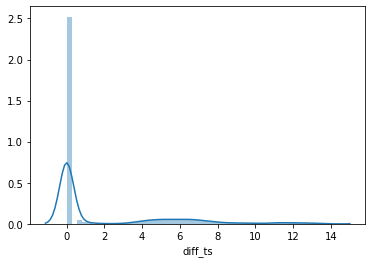

In [176]:
sns.distplot(np.log(df_event_sorted['diff_ts']+1))

In [181]:
# Add Travel duration 
df_event_sorted['tr_duration'] = (df_event_sorted['date_to'] - df_event_sorted['date_from'] )/np.timedelta64(1,'D')
#df_event_sorted['tr_duration'] = df_event_sorted['tr_duration'].astype('int')
df_event_sorted.head(10)

,ts,event_type,user_id,date_from,date_to,origin,destination,num_adults,num_children,max_count,act_count,diff_ts,tr_duration
0,2017-04-29 17:59:51,search,000069,2017-05-10,2017-05-26,FRA,ALG,2,3,1,1,0,16.0
1,2017-04-28 19:14:23,search,00019d,2017-09-15,2017-10-13,PAR,SSA,4,0,1,1,0,28.0
2,2017-04-24 21:25:10,search,0002e3,2017-05-01,2017-05-01,PAR,ATH,1,0,1,1,0,0.0
3,2017-04-27 16:34:02,search,000332,2017-06-08,2017-07-07,NCE,TLV,1,0,4,1,0,29.0
4,2017-04-27 16:35:35,search,000332,2017-06-08,2017-07-07,NCE,TLV,1,0,4,2,93,29.0
5,2017-04-27 16:39:10,search,000332,2017-06-08,2017-07-07,NCE,TLV,2,0,4,3,215,29.0
6,2017-04-27 21:24:01,search,000332,2017-06-08,2017-07-07,TLV,NCE,2,0,4,4,17091,29.0
7,2017-04-29 01:06:18,search,0004e1,2017-07-19,2017-07-25,MUC,ROM,1,0,2,1,0,6.0
8,2017-04-29 01:06:41,search,0004e1,2017-07-19,2017-07-25,MUC,ROM,1,0,2,2,23,6.0
9,2017-04-29 23:42:19,search,0004f1,2017-09-15,2017-10-05,LYS,YUL,2,0,2,1,0,20.0


In [182]:
df_event_sorted[df_event_sorted['tr_duration'].isna()]

,ts,event_type,user_id,date_from,date_to,origin,destination,num_adults,num_children,max_count,act_count,diff_ts,tr_duration
3582,2017-04-29 21:31:57,search,139d74,NaT,2017-09-02,CGN,AYT,0,0,3,1,0,NaN
3583,2017-04-29 21:36:04,search,139d74,NaT,2017-09-02,CGN,AYT,0,0,3,2,247,NaN
3584,2017-04-29 21:37:20,search,139d74,NaT,2017-09-02,CGN,AYT,0,0,3,3,76,NaN
3885,2017-05-01 00:18:23,search,15568d,NaT,2017-06-20,AMS,IST,0,0,1,1,0,NaN
7768,2017-04-23 19:02:48,search,299320,NaT,NaT,BRU,TLS,0,0,1,1,0,NaN
7981,2017-04-24 21:13:32,search,2ac874,NaT,NaT,AYT,DUS,0,0,1,1,0,NaN
11598,2017-04-27 15:58:06,search,3e44c4,NaT,2017-06-23,AMS,MAD,0,0,1,1,0,NaN
12817,2017-04-27 17:52:49,search,450011,NaT,2018-04-02,BKK,DUS,0,0,2,1,0,NaN
12818,2017-04-27 19:35:16,search,450011,NaT,2017-07-10,DUS,BKK,0,0,2,2,6147,NaN
13181,2017-04-28 23:24:26,search,46cad7,NaT,2017-05-24,AMS,MUC,0,0,4,1,0,NaN


In [185]:
df_event_sorted[df_event_sorted['tr_duration'] == 0]['event_type'].value_counts()

search    7649
book       397
Name: event_type, dtype: int64

In [187]:
# Add day of week of user activities
#  It is assumed the week starts on Monday, which is denoted by 0 and ends on Sunday which is denoted by 6
df_event_sorted['ts_dow'] = df_event_sorted['ts'].dt.dayofweek

In [191]:
df_event_sorted['from_dow'] = df_event_sorted['date_from'].dt.dayofweek
df_event_sorted['to_dow'] = df_event_sorted['date_to'].dt.dayofweek

In [192]:
df_event_sorted['from_dow'].value_counts()

2.0    9647
3.0    8547
1.0    6779
5.0    6631
4.0    5321
0.0    5254
6.0    4806
Name: from_dow, dtype: int64

In [193]:
df_event_sorted['to_dow'].value_counts()

4.0    10250
3.0     7884
5.0     7261
2.0     6398
1.0     5247
6.0     5085
0.0     4879
Name: to_dow, dtype: int64

In [197]:
titanic = sns.load_dataset("titanic")

In [198]:
titanic.head(5)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


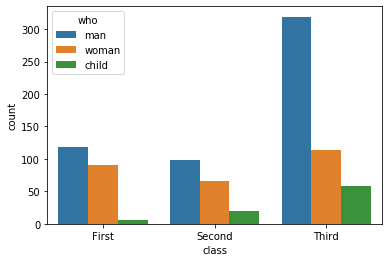

In [200]:
sns.countplot(x="class", hue="who", data=titanic)

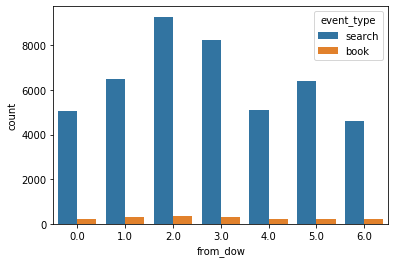

In [201]:
sns.countplot(x='from_dow', hue='event_type', data=df_event_sorted)

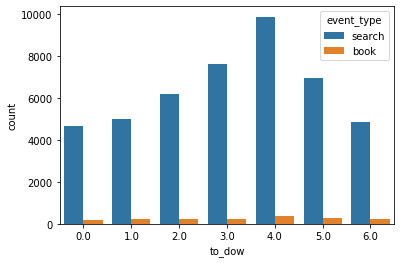

In [204]:
sns.countplot(x='to_dow', hue='event_type', data=df_event_sorted)

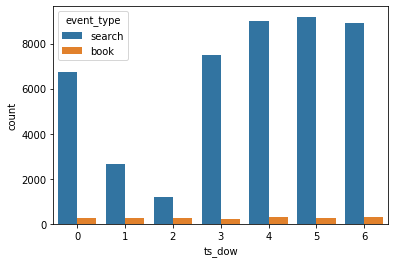

In [202]:
sns.countplot(x='ts_dow', hue='event_type', data=df_event_sorted)

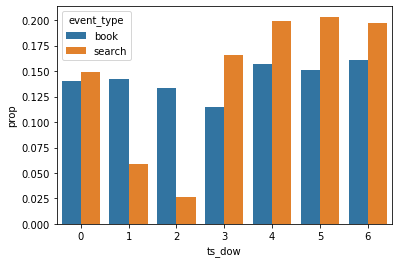

In [203]:
prop_df = (df_event_sorted['ts_dow']
           .groupby(df_event_sorted['event_type'])
           .value_counts(normalize=True)
           .rename('prop')
           .reset_index())

sns.barplot(x='ts_dow', y='prop', hue='event_type', data=prop_df)

In [211]:
df_event_sorted.head(2)

,ts,event_type,user_id,date_from,date_to,origin,destination,num_adults,num_children,max_count,act_count,diff_ts,tr_duration,ts_dow,from_dow,to_dow,ts_hour
0,2017-04-29 17:59:51,search,000069,2017-05-10,2017-05-26,FRA,ALG,2,3,1,1,0,16.0,5,2.0,4.0,17
1,2017-04-28 19:14:23,search,00019d,2017-09-15,2017-10-13,PAR,SSA,4,0,1,1,0,28.0,4,4.0,4.0,19


In [210]:
df_event_sorted['ts_hour'] = df_event_sorted['ts'].dt.hour

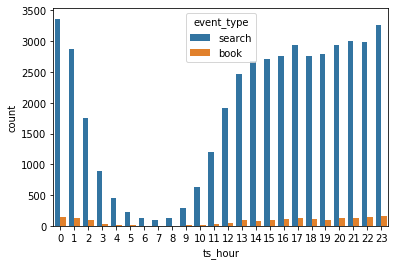

In [215]:
sns.countplot(x='ts_hour', hue='event_type', data=df_event_sorted)

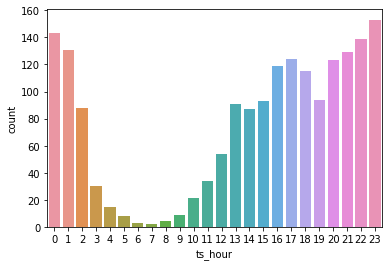

In [220]:
sns.countplot(df_event_sorted[df_event_sorted['event_type'] == 'book']['ts_hour'])

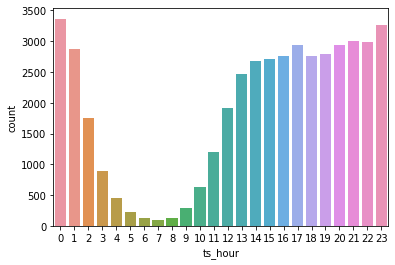

In [221]:
sns.countplot(df_event_sorted[df_event_sorted['event_type'] == 'search']['ts_hour'])

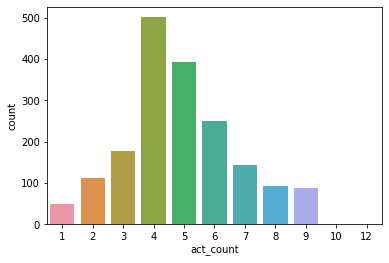

In [222]:
sns.countplot(df_event_sorted[df_event_sorted['event_type'] == 'book']['act_count'])

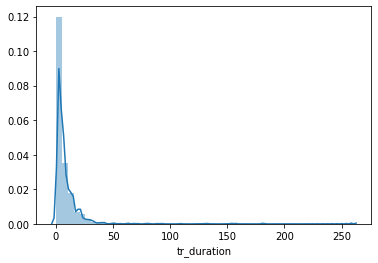

In [224]:
sns.distplot(df_event_sorted[df_event_sorted['event_type'] == 'book']['tr_duration'].fillna(0))

In [229]:
df_event_sorted.head(5)

,ts,event_type,user_id,date_from,date_to,origin,destination,num_adults,num_children,max_count,act_count,diff_ts,tr_duration,ts_dow,from_dow,to_dow,ts_hour
0,2017-04-29 17:59:51,search,000069,2017-05-10,2017-05-26,FRA,ALG,2,3,1,1,0,16.0,5,2.0,4.0,17
1,2017-04-28 19:14:23,search,00019d,2017-09-15,2017-10-13,PAR,SSA,4,0,1,1,0,28.0,4,4.0,4.0,19
2,2017-04-24 21:25:10,search,0002e3,2017-05-01,2017-05-01,PAR,ATH,1,0,1,1,0,0.0,0,0.0,0.0,21
3,2017-04-27 16:34:02,search,000332,2017-06-08,2017-07-07,NCE,TLV,1,0,4,1,0,29.0,3,3.0,4.0,16
4,2017-04-27 16:35:35,search,000332,2017-06-08,2017-07-07,NCE,TLV,1,0,4,2,93,29.0,3,3.0,4.0,16


In [256]:
df_event_sorted['origin_changed'] = df_event_sorted['origin'] != df_event_sorted['origin'].shift(1).fillna(df_event_sorted['origin'])
df_event_sorted['origin_changed'] = df_event_sorted['origin_changed'] * (df_event_sorted['act_count']>1)
df_event_sorted['origin_changed'] = df_event_sorted['origin_changed'].astype(int)

In [263]:
df_event_sorted['destin_changed'] = df_event_sorted['destination'] != df_event_sorted['destination'].shift(1).fillna(df_event_sorted['destination'])
df_event_sorted['destin_changed'] = df_event_sorted['destin_changed'] * (df_event_sorted['act_count']>1)
df_event_sorted['destin_changed'] = df_event_sorted['destin_changed'].astype(int)

In [264]:
df_event_sorted.head(7)

,ts,event_type,user_id,date_from,date_to,origin,destination,num_adults,num_children,max_count,act_count,diff_ts,tr_duration,ts_dow,from_dow,to_dow,ts_hour,origin_changed,destin_changed
0,2017-04-29 17:59:51,search,000069,2017-05-10,2017-05-26,FRA,ALG,2,3,1,1,0,16.0,5,2.0,4.0,17,0,0
1,2017-04-28 19:14:23,search,00019d,2017-09-15,2017-10-13,PAR,SSA,4,0,1,1,0,28.0,4,4.0,4.0,19,0,0
2,2017-04-24 21:25:10,search,0002e3,2017-05-01,2017-05-01,PAR,ATH,1,0,1,1,0,0.0,0,0.0,0.0,21,0,0
3,2017-04-27 16:34:02,search,000332,2017-06-08,2017-07-07,NCE,TLV,1,0,4,1,0,29.0,3,3.0,4.0,16,0,0
4,2017-04-27 16:35:35,search,000332,2017-06-08,2017-07-07,NCE,TLV,1,0,4,2,93,29.0,3,3.0,4.0,16,0,0
5,2017-04-27 16:39:10,search,000332,2017-06-08,2017-07-07,NCE,TLV,2,0,4,3,215,29.0,3,3.0,4.0,16,0,0
6,2017-04-27 21:24:01,search,000332,2017-06-08,2017-07-07,TLV,NCE,2,0,4,4,17091,29.0,3,3.0,4.0,21,1,1


In [260]:
df_event_sorted[df_event_sorted['origin_changed'] == 1]['event_type'].value_counts()

search    1642
book        61
Name: event_type, dtype: int64

In [261]:
df_event_sorted['event_type'].value_counts()

search    45198
book       1809
Name: event_type, dtype: int64

In [262]:
61/1642, 1809/45198

(0.03714981729598051, 0.04002389486260454)

In [265]:
df_event_sorted[df_event_sorted['destin_changed'] == 1]['event_type'].value_counts()

search    1749
book        53
Name: event_type, dtype: int64

In [266]:
53/1749

0.030303030303030304

In [267]:
df_event_sorted['total_passenger'] = df_event_sorted['num_adults']+df_event_sorted['num_children']

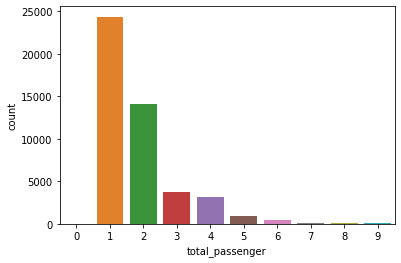

In [268]:
sns.countplot(df_event_sorted['total_passenger'])

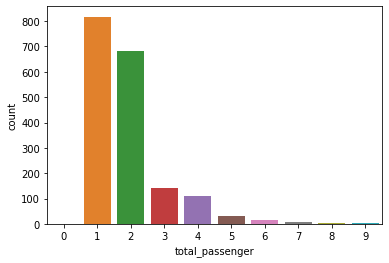

In [269]:
sns.countplot(df_event_sorted[df_event_sorted['event_type'] == 'book']['total_passenger'])

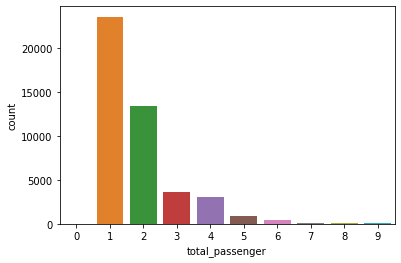

In [270]:
sns.countplot(df_event_sorted[df_event_sorted['event_type'] == 'search']['total_passenger'])

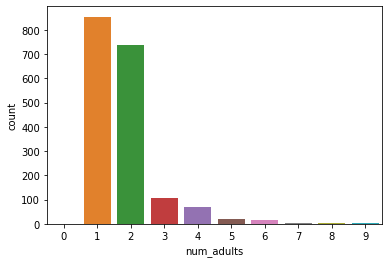

In [271]:
sns.countplot(df_event_sorted[df_event_sorted['event_type'] == 'book']['num_adults'])

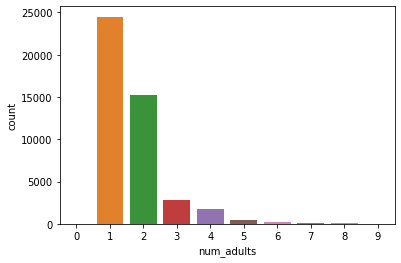

In [272]:
sns.countplot(df_event_sorted[df_event_sorted['event_type'] == 'search']['num_adults'])

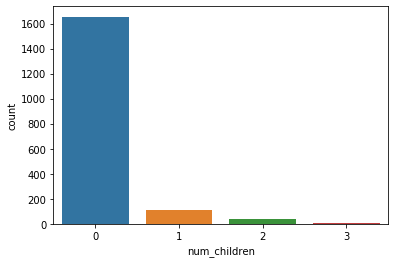

In [273]:
sns.countplot(df_event_sorted[df_event_sorted['event_type'] == 'book']['num_children'])

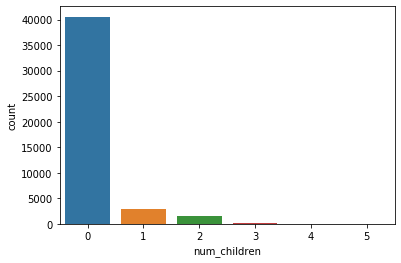

In [274]:
sns.countplot(df_event_sorted[df_event_sorted['event_type'] == 'search']['num_children'])

In [275]:
df_event_sorted['event_type'].value_counts()

search    45198
book       1809
Name: event_type, dtype: int64

In [276]:
1809/45198

0.04002389486260454

In [279]:
df_event_sorted['ts_day'] = df_event_sorted['ts'].dt.day
df_event_sorted['ts_month'] = df_event_sorted['ts'].dt.month

In [280]:
df_event_sorted.head(2)

,ts,event_type,user_id,date_from,date_to,origin,destination,num_adults,num_children,max_count,...,tr_duration,ts_dow,from_dow,to_dow,ts_hour,origin_changed,destin_changed,total_passenger,ts_day,ts_month
0,2017-04-29 17:59:51,search,000069,2017-05-10,2017-05-26,FRA,ALG,2,3,1,...,16.0,5,2.0,4.0,17,0,0,5,29,4
1,2017-04-28 19:14:23,search,00019d,2017-09-15,2017-10-13,PAR,SSA,4,0,1,...,28.0,4,4.0,4.0,19,0,0,4,28,4


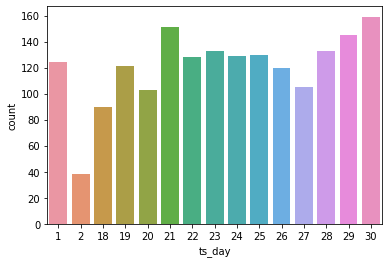

In [281]:
sns.countplot(df_event_sorted[df_event_sorted['event_type'] == 'book']['ts_day'])

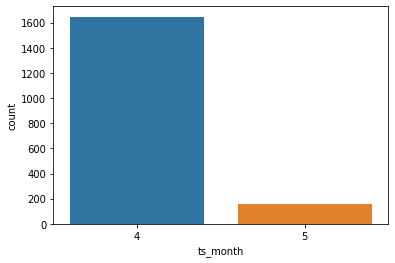

In [282]:
sns.countplot(df_event_sorted[df_event_sorted['event_type'] == 'book']['ts_month'])

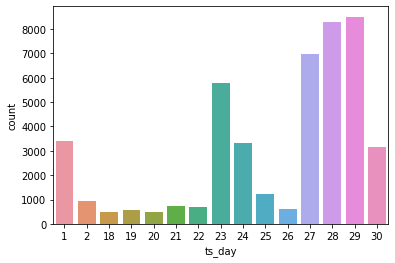

In [283]:
sns.countplot(df_event_sorted[df_event_sorted['event_type'] == 'search']['ts_day'])

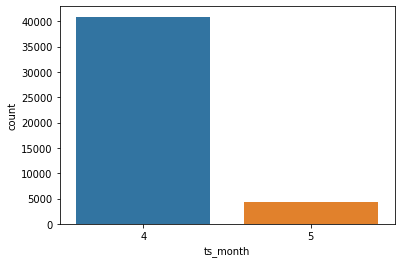

In [284]:
sns.countplot(df_event_sorted[df_event_sorted['event_type'] == 'search']['ts_month'])

In [285]:
df_event_sorted['ts'].max(), df_event_sorted['ts'].min()

(Timestamp('2017-05-02 04:06:34'), Timestamp('2017-04-18 04:41:09'))